tmrg = 985.0361328124999


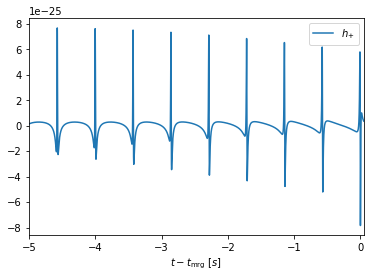

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


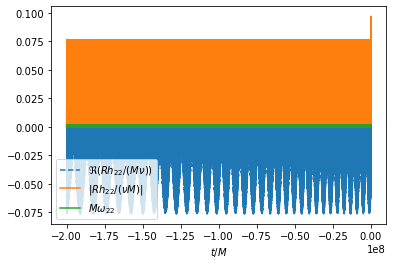

In [16]:
# Produce a waveform compatible with GW150914

import sys
sys.path.insert(1,'../')
import EOBRun_module

import numpy as np
import matplotlib.pyplot as plt

# Source parameters
# https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102
M1 = 0.5 # Mo
M2 = 0.5 # Mo
Deff = 400 # Mpc
iota = 150./360.*np.pi

# Use 22 mode only
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
k = modes_to_k([[2,2]])

# Define a dictionary with input parameters
pars = {
    'M'                  : M1+M2,
    'q'                  : M1/M2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,      # TD
    'arg_out'            : 1,      # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
    'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : Deff,
    'inclination'        : iota,
    'output_hpc'         : 0,
    'ecc':0.9
}

# Run the WF generator
t, hp, hc, hlm,b = EOBRun_module.EOBRunPy(pars)

# Approximate merger time
h = hp - 1j*hp
tmrg = t[np.argmax(np.abs(h))]
print('tmrg = {}'.format(tmrg))
t = t - tmrg # shift to mrg

# Plot h
plt.plot(t, hp, label=r'$h_{+}$')
# plt.plot(t, hc, label=r'$h_{\times}$')
plt.xlim([-5,0.05])
plt.xlabel(r'$t-t_{\rm mrg}$ $[s]$')
plt.legend()
plt.show()

# 22 mode
A22   = hlm['1'][0]
Phi22 = hlm['1'][1]

# t/M, geometric units
GMo = 4.925490947*1e-6 # s
t *= 1./((M1+M2)*GMo) 

# GW frequency
omg22 = np.zeros_like(Phi22)
omg22[1:] = np.diff(Phi22)/np.diff(t)

# Plot 22 mode in geometric units
plt.plot(t, A22*np.cos(Phi22), '--', label=r'$\Re{(Rh_{22}/(M\nu))}$')
plt.plot(t, A22, label=r'$|Rh_{22}/(\nu M)|$')
plt.plot(t, omg22, label=r'$M\omega_{22}$')
#plt.xlim([-500.,100])
plt.xlabel(r'$t/M$')
plt.legend()
plt.show()



In [ ]:
import time
import pycbc
import pycbc.noise
import pylab
import lal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pycbc import psd, filter
from matplotlib import rc
import gwpy
from gwpy.frequencyseries import FrequencySeries
from pycbc import types
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})

from multiprocessing import Pool
import h5py
import pandas as pd
import json
import os
import csv
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

In [ ]:
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants
import matplotlib.pyplot as pp

#print(td_approximants())

#WHAT IS THE STARTING GRAVITATIONAL WAVE FREQUENCY f_lower?
#Should I consider spinlz?


hp, hc = get_td_waveform(approximant='TEOBResumS',
                                 mass1=0.5,
                                 mass2=0.5,
                                 #spin1z=0.9,
                                 delta_t=1.0/4096,
                                 f_lower=40)


pp.plot(hp.sample_times, hp, label='TEOBResumS')

pp.ylabel('Strain (plus polarization)')
pp.xlabel('Time (s)')
#pp.ylim(-2,2)
pp.legend()
pp.show()


In [11]:
import numpy
import matplotlib.pyplot as pp
import pycbc.waveform
from pycbc.types import TimeSeries


def test_waveform(**args):
    flow = args['f_lower'] # Required parameter
    dt = args['delta_t']   # Required parameter
    pars = args['pars']  # New parameters for my model
    
#     pars = {
#     'M'                  : M1+M2,
#     'q'                  : M1/M2,
#     'Lambda1'            : 0.,
#     'Lambda2'            : 0.,     
#     'chi1'               : 0.,
#     'chi2'               : 0.,
#     'domain'             : 0,      # TD
#     'arg_out'            : 1,      # Output hlm/hflm. Default = 0
#     'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
#     'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
#     'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
#     'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
#     'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
#     'distance'           : Deff,
#     'inclination'        : iota,
#     'output_hpc'         : 0
# }
    
    t = numpy.arange(0, 10, dt)
    a = t

    #wf = numpy.exp(2.0j * numpy.pi * f * t) * a
    t,hp,hc,hlm,b=EOBRun_module.EOBRunPy(pars)
    wf=hp+1j*hc
    # wf = hp + i hx 

    # Return product should be a pycbc time series in this case for
    # each GW polarization
    #
    #
    # Note that by convention, the time at 0 is a fiducial reference.
    
    # For CBC waveforms, this would be set to where the merger occurs
    offset = - len(t) * dt
    wf = TimeSeries(wf, delta_t=dt, epoch=offset)
    # wf --> hp hc
    return hp, hc


# This tells pycbc about our new waveform so we can call it from standard
# pycbc functions. If this were a frequency-domain model, select 'frequency'
# instead of 'time' to this function call.
pycbc.waveform.add_custom_waveform('test', test_waveform, 'time', force=True)


In [12]:
pars={
    'M'                  : M1+M2,
    'q'                  : M1/M2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,      # TD
    'arg_out'            : 1,      # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
    'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : Deff,
    'inclination'        : iota,
    'output_hpc'         : 0,
    'ecc':0.06
}

hp, hc = pycbc.waveform.get_td_waveform(approximant="test",
                                        f_lower=20,
                                        delta_t=1.0/4096,
                                       pars=pars)

In [13]:
h_eob_phys = (hp +1j* hc).data

In [15]:
#tlen = int(1.0 / (delta_t) / (1.0/4))
tlen = int(1.0 / (1.0/(44096)) / (1.0/4))
times_eob=hp_eob.sample_times.data

AttributeError: 'numpy.ndarray' object has no attribute 'sample_times'